# Notebook de développement du modèle

In [22]:
import os
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig,OmegaConf
import sys
from datasets import load_dataset
from transformers import ConvNextImageProcessor,AutoImageProcessor
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# On l'ajoute au chemin de recherche de Python s'il n'y est pas déjà
if project_root not in sys.path:
    sys.path.append(project_root)
from src.cyprus_fish.data import CyprusFishDataset

os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Change the path of some HF environment variables to store the download data (model and dataset) from the hub to a choosen location
os.environ["HF_HOME"] = "../.cache"
os.environ["HF_HUB_CACHE"] = "../.cache"
os.environ["HF_DATASETS_CACHE"] = "../.cache"

In [6]:
ds = load_dataset("JayRay5/cyprus-fish-dataset")
processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [23]:
with initialize(version_base=None, config_path="../configs"):
    
    # 2. Composition de la configuration
    # Tu peux même surcharger des valeurs à la volée avec 'overrides'
    cfg = compose(config_name="config")

# (Optionnel) Affiche la config pour vérifier que tout est bon
print(OmegaConf.to_yaml(cfg))

prepare_data:
  raw_path: data/raw
  processed_path: data/processed
  split_ratio:
  - 0.8
  - 0.2
  valid_extensions:
  - .jpg
  - .jpeg
  - .png
  seed: 42
  hf_repo_id: JayRay5/cyprus-fish-dataset
  hf_private: true
data:
  hf_repo_id: JayRay5/cyprus-fish-dataset
  revision: be9dbe8f4048fe5c399a71713fcb8d0cfdd37ae5
  num_classes: 5
  class_names:
  - apogon_imberbis
  - epinephelus_marginatus
  - pempheris_vanicolensis
  - sparisoma_cretense
  - thalassoma_pavo
processor:
  hf_repo_id: facebook/convnext-tiny-224
  revision: 6166b7613034066690a621d8bf25ffdf181a34f0



In [26]:
train_dataset = CyprusFishDataset(
    repo_id=cfg.data.hf_repo_id,
    repo_revision=cfg.data.revision,
    processor_name=cfg.processor.hf_repo_id,
    processor_revision=cfg.processor.revision,
    split="train",
    num_classes=cfg.data.num_classes
)

In [29]:
train_dataset[190][0].shape

torch.Size([3, 224, 224])

## Data Management

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn 
import tensorflow as tf
from keras import  layers, models


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
import sys
from pathlib import Path

def rename_images(folder_path, prefix):
    """
    Renomme toutes les images d'un dossier avec un préfixe et un index.
    Ex: prefix_000.jpg, prefix_001.jpg
    """
    folder = Path(folder_path)
    
    if not folder.exists():
        print(f"❌ Erreur : Le dossier {folder} n'existe pas.")
        return

    # Extensions d'images supportées
    valid_extensions = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}
    
    # Récupérer les fichiers et les trier (pour garder l'ordre actuel si possible)
    files = [f for f in folder.iterdir() if f.is_file() and f.suffix.lower() in valid_extensions]
    files.sort()

    print(f"📂 Traitement de : {folder.name} ({len(files)} images)")

    count = 0
    for index, file in enumerate(files):
        # f"{index:04d}" génère 0000, 0001, ... (utile jusqu'à 9999 images)
        new_name = f"{prefix}_{index:04d}{file.suffix.lower()}"
        new_path = folder / new_name

        # Sécurité : Si le fichier porte déjà le bon nom, on passe
        if new_path == file:
            continue
            
        # Sécurité : Si le nom cible existe déjà (conflit), on alerte
        if new_path.exists():
            print(f"⚠️  Conflit : {new_name} existe déjà. Skipped.")
            continue

        file.rename(new_path)
        count += 1

    print(f"✅ {count} images renommées avec succès dans '{folder.name}'\n")

if __name__ == "__main__":
    # --- CONFIGURATION ---
    # Tu peux l'utiliser pour tous tes dossiers d'un coup
    
    root_data = Path("../data/raw") # Ton dossier racine
    
    # Liste de tes dossiers (ou scan automatique)
    species_folders = [
        "apogon_imberbis",
        "epinephelus_marginatus",
        "pempheris_vanicolensis",
        "sparisoma_cretense",
        "thalassoma_pavo"
    ]

    for species in species_folders:
        # On utilise le nom du dossier comme préfixe pour le fichier
        # ex: data/raw/thalassoma_pavo -> thalassoma_pavo_0001.jpg
        rename_images(root_data / species, prefix=species)

📂 Traitement de : apogon_imberbis (62 images)
✅ 62 images renommées avec succès dans 'apogon_imberbis'

📂 Traitement de : epinephelus_marginatus (61 images)
✅ 61 images renommées avec succès dans 'epinephelus_marginatus'

📂 Traitement de : pempheris_vanicolensis (61 images)
✅ 61 images renommées avec succès dans 'pempheris_vanicolensis'

📂 Traitement de : sparisoma_cretense (46 images)
✅ 46 images renommées avec succès dans 'sparisoma_cretense'

📂 Traitement de : thalassoma_pavo (62 images)
✅ 62 images renommées avec succès dans 'thalassoma_pavo'



In [35]:
fish_list=['apognon','epinephelus_marginatus','girelle_paon','pempheris_vanicolensis','sparisoma_cretense']
original_data_path = './data/original/'
synthetic_data_path = './data/synthetic/'

### Rename files

In [3]:

'''
for espece in liste_poissons:
    root = r"data/generated/color/{}".format(espece)
    print(root)
    count = 0
    for dirs, subdir, files in os.walk(root):
        for file in files:
            os.rename(root+"/"+file,root+"/{}{}.jpg".format(espece,count))
            count+=1

'''


'\nfor espece in liste_poissons:\n    root = r"data/generated/color/{}".format(espece)\n    print(root)\n    count = 0\n    for dirs, subdir, files in os.walk(root):\n        for file in files:\n            os.rename(root+"/"+file,root+"/{}{}.jpg".format(espece,count))\n            count+=1\n\n'

### Stats

<Axes: >

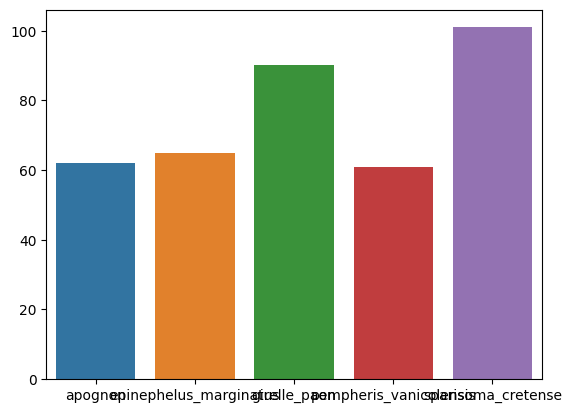

In [70]:
fish_list
nb_samples = {} 
for f in fish_list:
    nb_samples[f] = len(os.listdir('{}/{}'.format(original_data_path,f)))

nb_samples
sn.barplot(x=list(nb_samples.keys()), y=list(nb_samples.values()))


### Generation d'image

In [62]:
data_augmentation = layers.RandomRotation(0.4)
 
#function that take in arguments the path to the original image
#the destination path
#a counter that is the number of the image for the current fold on which we are looping
#create 3 new images from the original by randomly rotating it and save them in the designated folder
def generate_save_new_img_from_path(original_image_path,destination_image_path,counter):
    image = tf.io.read_file(original_image_path)
    image = tf.image.decode_png(image,channels=3)
    for k in range(3):
      new_image = data_augmentation(image)
      tf.keras.utils.save_img(destination_image_path+str(counter+k)+'.jpg', new_image)

In [63]:
for specie in fish_list:
    counter = 0
    for i in range(31,60,1):
        generate_save_new_img_from_path(original_data_path+'{}/{}{}'.format(specie,specie,i)+'.jpg',synthetic_data_path+'/{}/{}'.format(specie,specie),counter)
        counter+=3

## Création du modèle

### Modele créer en local

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 150, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(5,activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#model.summary()

In [ ]:
epochs=10
history = model.fit(
  training_data,
  y_training_data,
  validation_data=(test_data,y_test_data),
  epochs=epochs,
  batch_size=5
)

Epoch 1/10
226/226 [==============================] - 54s 223ms/step - loss: 1.5235 - accuracy: 0.3052 - val_loss: 1.4030 - val_accuracy: 0.3799
Epoch 2/10
226/226 [==============================] - 48s 211ms/step - loss: 1.3160 - accuracy: 0.3886 - val_loss: 1.2680 - val_accuracy: 0.3826
Epoch 3/10
226/226 [==============================] - 48s 211ms/step - loss: 1.1683 - accuracy: 0.5067 - val_loss: 1.0273 - val_accuracy: 0.6121
Epoch 4/10
226/226 [==============================] - 48s 210ms/step - loss: 0.9605 - accuracy: 0.6335 - val_loss: 0.9110 - val_accuracy: 0.6702
Epoch 5/10
226/226 [==============================] - 48s 210ms/step - loss: 0.8370 - accuracy: 0.6619 - val_loss: 0.8702 - val_accuracy: 0.6544
Epoch 6/10
226/226 [==============================] - 48s 211ms/step - loss: 0.7567 - accuracy: 0.7054 - val_loss: 0.7388 - val_accuracy: 0.7441
Epoch 7/10
226/226 [==============================] - 47s 209ms/step - loss: 0.6341 - accuracy: 0.7551 - val_loss: 0.7182 - val_ac

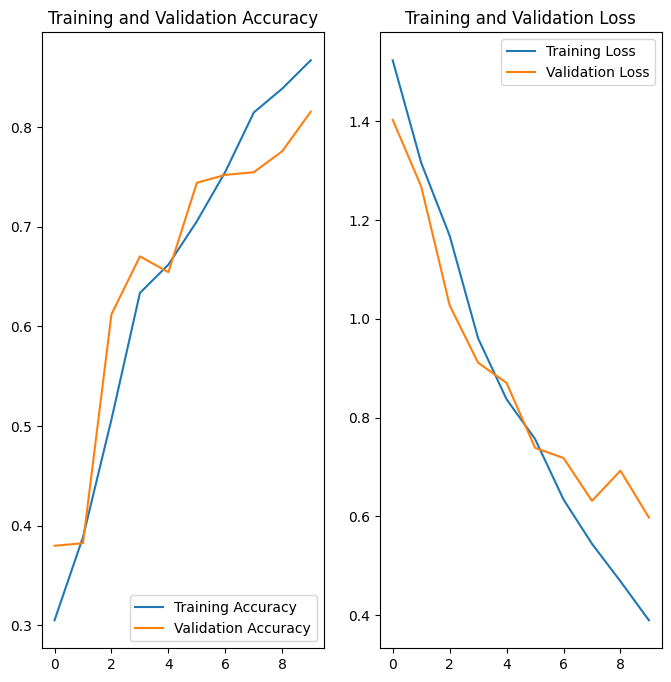

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Note: les données d'entrainement ont été obtenu par data augmention via les données de validations, il y a donc un risque d'overfiting.